In this notebook, we demonstrate how to use the `DistillationPress` class which distills the KV cache into a smaller. This press is based on the following observation: the attention mechanoism in the transformer model can be seen as a MLP with 2 layers and a softmax non-linearity:

$$A(q, K, V) = V \cdot \text{softmax}(\frac{K}{\sqrt{d_k}} \cdot q)$$

where $q , K, V$ are the query (input of the MLP), key, and value matrices (weights of the MLP). 

After applying the `ExpectedAttentionPress` to prune the least important tokens, we finetune the compressed weights $K_c$ and $V_c$ to approximate the original weights $K$ and $V$. We sample queries $q$ using the expected query distribution $\mathcal{Q}$ estimated in the `ExpectedAttentionPress`. We seek to minimize the following loss:

$$ \text{distillation loss} = \mathbb{E_{q \sim \mathcal{Q}}}[||A(q, K, V) - A(q, K_c, V_c)||^2]$$

In [1]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline

from transformers import pipeline

from kvpress import ExpectedAttentionPress, DistillationPress

/mnt/workspace/projects/kvpress/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# End to end example

In [2]:
# Load pipeline

device = "cuda:0"
ckpt = "meta-llama/Meta-Llama-3.1-8B-Instruct"
attn_implementation = "flash_attention_2"
pipe = pipeline("kv-press-text-generation", model=ckpt, device=device, torch_dtype="auto", model_kwargs={"attn_implementation":attn_implementation})

# Load data

url = "https://en.wikipedia.org/wiki/Nvidia"
content = requests.get(url).content
soup = BeautifulSoup(content, "html.parser")
context = "".join([p.text for p in soup.find_all("p")]) + "\n\n"
tokens = pipe.tokenizer.encode(context, return_tensors="pt").to(device)
print(f"Number of tokens: {tokens.size(1)}")

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  8.78it/s]


Number of tokens: 8856


In [3]:
# Load presses

compression_ratio = 0.8
press1 = ExpectedAttentionPress(compression_ratio)
press2 = DistillationPress(compression_ratio)

# Run the pipeline on a single question

question = "Complete this sentence: The Nvidia GeForce Partner Program was a ..."
true_answer = "marketing program designed to provide partnering companies with benefits such as public relations support, video game bundling, and marketing development funds."
pred_answer1 = pipe(context, question=question, press=press1)["answer"]
pred_answer2 = pipe(context, question=question, press=press2)["answer"]

print(f"Question:    {question}")
print(f"Answer:      {true_answer}")
print("Without distillation:")
print(f"Prediction: {pred_answer1}") 
print("With distillation:")
print(f"Prediction: {pred_answer2}")

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


Question:    Complete this sentence: The Nvidia GeForce Partner Program was a ...
Answer:      marketing program designed to provide partnering companies with benefits such as public relations support, video game bundling, and marketing development funds.
Without distillation:
Prediction: marketing program designed to provide benefits to companies that partnered with Nvidia, but it was also criticized as a possible anti-competitive practice.
With distillation:
Prediction: marketing program designed to provide partnering companies with benefits such as public relations support, marketing materials, and access to Nvidia's technology and expertise.


Text(0.5, 1.0, 'Distillation loss per layer')

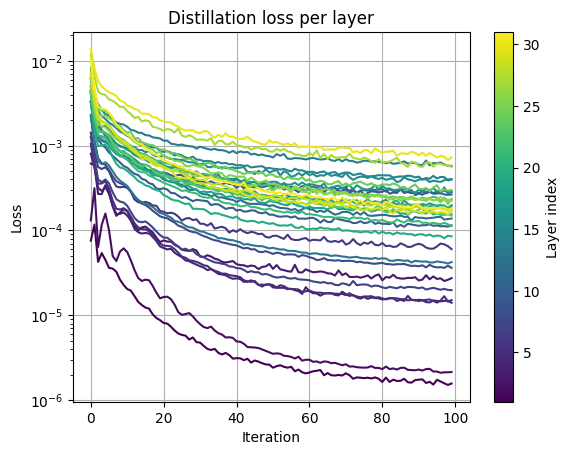

In [4]:
# Display distillation losses

fig, ax = plt.subplots()
cmap = plt.get_cmap("viridis")
n = len(press2.losses) - 1
for i, loss in enumerate(press2.losses):
    ax.plot(loss, color=cmap(i / n))
plt.xlabel("Iteration")
plt.ylabel("Loss")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(1, n)), ax=ax, label="Layer index")
plt.grid()
plt.yscale("log")
plt.title("Distillation loss per layer")

# Under the hood

Text(0, 0.5, 'Scaled dot product attention')

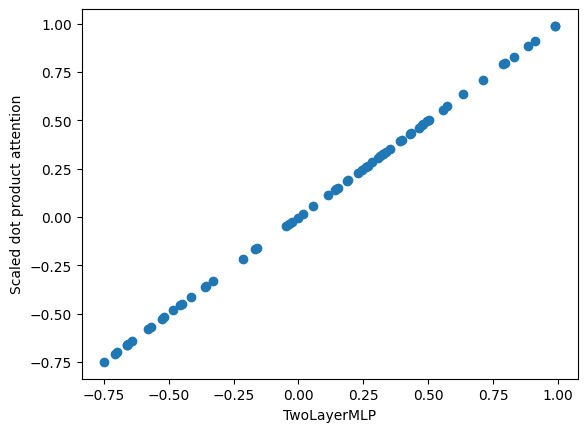

In [5]:
import torch
import torch.nn.functional as F

from kvpress.presses.distillation_press import TwoLayerMLP

K = torch.randn(1, 1, 8, 8)
V = torch.randn(1, 1, 8, 8)
Q = torch.randn(1, 1, 8, 8)


mlp = TwoLayerMLP(K, V)
with torch.no_grad():
    x1 = mlp(Q)
    x2 = F.scaled_dot_product_attention(Q, K, V)

plt.scatter(x1.flatten(), x2.flatten())
plt.xlabel("TwoLayerMLP")
plt.ylabel("Scaled dot product attention")